In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [12]:
def generate_synthetic_fico_data(n=5000):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 100, n) - np.random.choice([0, 20, 50, 100], n, p=[0.7, 0.15, 0.1, 0.05])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 850 - np.random.gamma(2, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data)
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.35, 'Amounts Owed': 0.30, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)
    
    return df

# Generate the dataset
fico_df = generate_synthetic_fico_data()


In [13]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] > np.random.rand(fico_df.shape[0])).astype(int)

In [14]:
fico_df.head()

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,749.671415,765.857188,769,814,497.391324,738.631284,0.999859,1
1,686.173570,786.658536,480,623,663.385434,676.796854,0.935817,1
2,764.768854,675.942702,564,619,362.555187,653.207428,0.579505,0
3,852.302986,687.332464,594,759,566.075177,726.113302,0.999505,1
4,676.584663,567.172030,546,831,660.268600,637.983101,0.231175,0


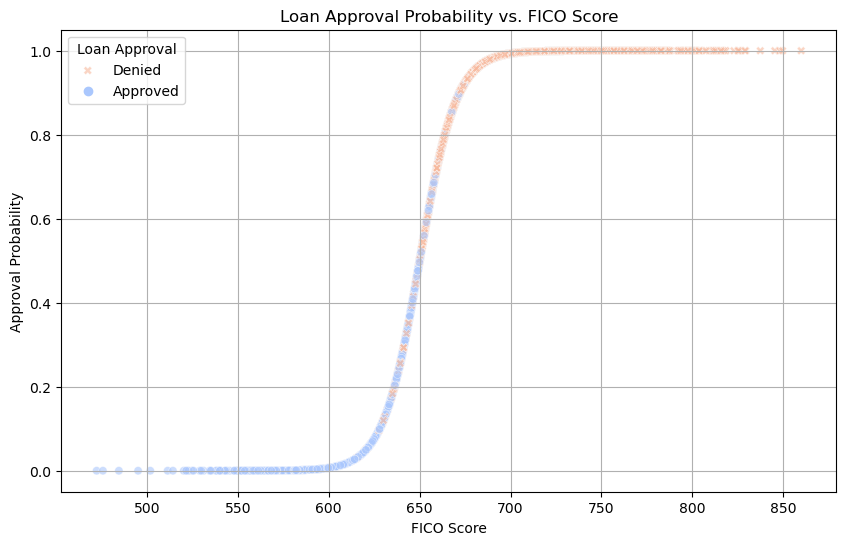

In [46]:
# Generate a sample 'Approval Probability' for visualization purposes
fico_df['Approval Probability'] = 1 / (1 + np.exp(-0.1 * (fico_df['FICO Score'] - 650)))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='FICO Score', y='Approval Probability', hue='True Label', style='True Label',
                data=fico_df, palette='coolwarm', markers=['o', 'X'], alpha=0.6)
plt.title('Loan Approval Probability vs. FICO Score')
plt.xlabel('FICO Score')
plt.ylabel('Approval Probability')
plt.legend(title='Loan Approval', labels=['Denied', 'Approved'])
plt.grid(True)
plt.show()

In [47]:
beta = np.array(weights.values())
print(beta)

dict_values([0.35, 0.3, 0.15, 0.1, 0.1])


In [44]:
beta = [0.35, 0.30, 0.15, 0.10, 0.10, -650]

# Approval probability function based on FICO score
def h(x, beta):
    return np.dot(x, beta[:-1]) + beta[-1]

# feature profile is first five cols of fico_fd
feature_prof_df = fico_df.iloc[:, :-2]
print(feature_prof_df.head())

# Cost function for changing feature profiles
def cost_function(x, x_0, cost_coefficient=1):
    return cost_coefficient * np.linalg.norm(x - x_0)

# Optimization for new feature profiles
new_profiles = feature_prof_df.copy()
for index, row in feature_prof_df.iterrows():
    x_0 = row.values[:-1]
    best_score = row['FICO Score']
    # Optimize the feature profile to minimize cost while keeping the FICO score above the threshold
    res = minimize(cost_function, x_0, args=(x_0), method='Nelder-Mead')
    new_profiles.loc[index] = np.append(res.x, best_score)

new_profiles.head()

   Payment History  Amounts Owed  Length of Credit History  Credit Mix  \
0       749.671415    765.857188                       769         814   
1       686.173570    786.658536                       480         623   
2       764.768854    675.942702                       564         619   
3       852.302986    687.332464                       594         759   
4       676.584663    567.172030                       546         831   

   New Credit  FICO Score  
0  497.391324  738.631284  
1  663.385434  676.796854  
2  362.555187  653.207428  
3  566.075177  726.113302  
4  660.268600  637.983101  


,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score
0,749.671415,765.857188,769,814,497.391324,738.631284
1,686.173570,786.658536,480,623,663.385434,676.796854
2,764.768854,675.942702,564,619,362.555187,653.207428
3,852.302986,687.332464,594,759,566.075177,726.113302
4,676.584663,567.172030,546,831,660.268600,637.983101


In [48]:
# add the true labels from the original dataset
new_profiles['True Label'] = fico_df['True Label']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='FICO Score', y='Approval Probability', hue='True Label', style='True Label',
                data=new_profiles, palette='coolwarm', markers=['o', 'X'], alpha=0.6)
plt.title('Loan Approval Probability vs. FICO Score')
plt.xlabel('FICO Score')
plt.ylabel('Approval Probability')
plt.legend(title='Loan Approval', labels=['Denied', 'Approved'])
plt.grid(True)
plt.show()

ValueError: Could not interpret value `Approval Probability` for parameter `y`

<Figure size 1000x600 with 0 Axes>